In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from PIL import Image
import numpy as np

In [6]:
mnist = fetch_openml('mnist_784')
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, shuffle=False)

/home/frog/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [16]:
# (x_train, t_train), (x_test, t_test) = (X_train.to_numpy(), y_train.to_numpy()), (X_test.to_numpy(), y_test.to_numpy())

In [7]:
def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

def _flatten(x):
    return x.reshape(28, 28)

def _normalize(x):
    return x / 255.0

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    (x_train, t_train), (x_test, t_test) = (X_train.to_numpy(), y_train.to_numpy()), (X_test.to_numpy(), y_test.to_numpy())
    
    t_train = t_train.astype(np.int32)
    t_test= t_test.astype(np.int32)
    if normalize:
        x_train = _normalize(x_train)
        x_test = _normalize(x_test)

    if not flatten:
        x_train = _flatten(x_train)
        x_test = _flatten(x_test)

    if one_hot_label:
        t_train = _change_one_hot_label(t_train)
        t_test = _change_one_hot_label(t_test)

    return (x_train, t_train), (x_test, t_test)
    


In [8]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)  # 5

print(img.shape)  # (784,)
img = img.reshape(28, 28)  # 把图像的形状变为原来的尺寸
print(img.shape)  # (28, 28)

img_show(img)

5
(784,)
(28, 28)


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/frog/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [9]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)


In [10]:
import pickle

In [11]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test


def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network


def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y


x, t = get_data()
print(x.shape)
print(t)
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p= np.argmax(y) # 获取概率最高的元素的索引
    if p == t[i]:
        accuracy_cnt += 1

print(accuracy_cnt, len(x))
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

(10000, 784)
[7 2 1 ... 4 5 6]
9352 10000
Accuracy:0.9352


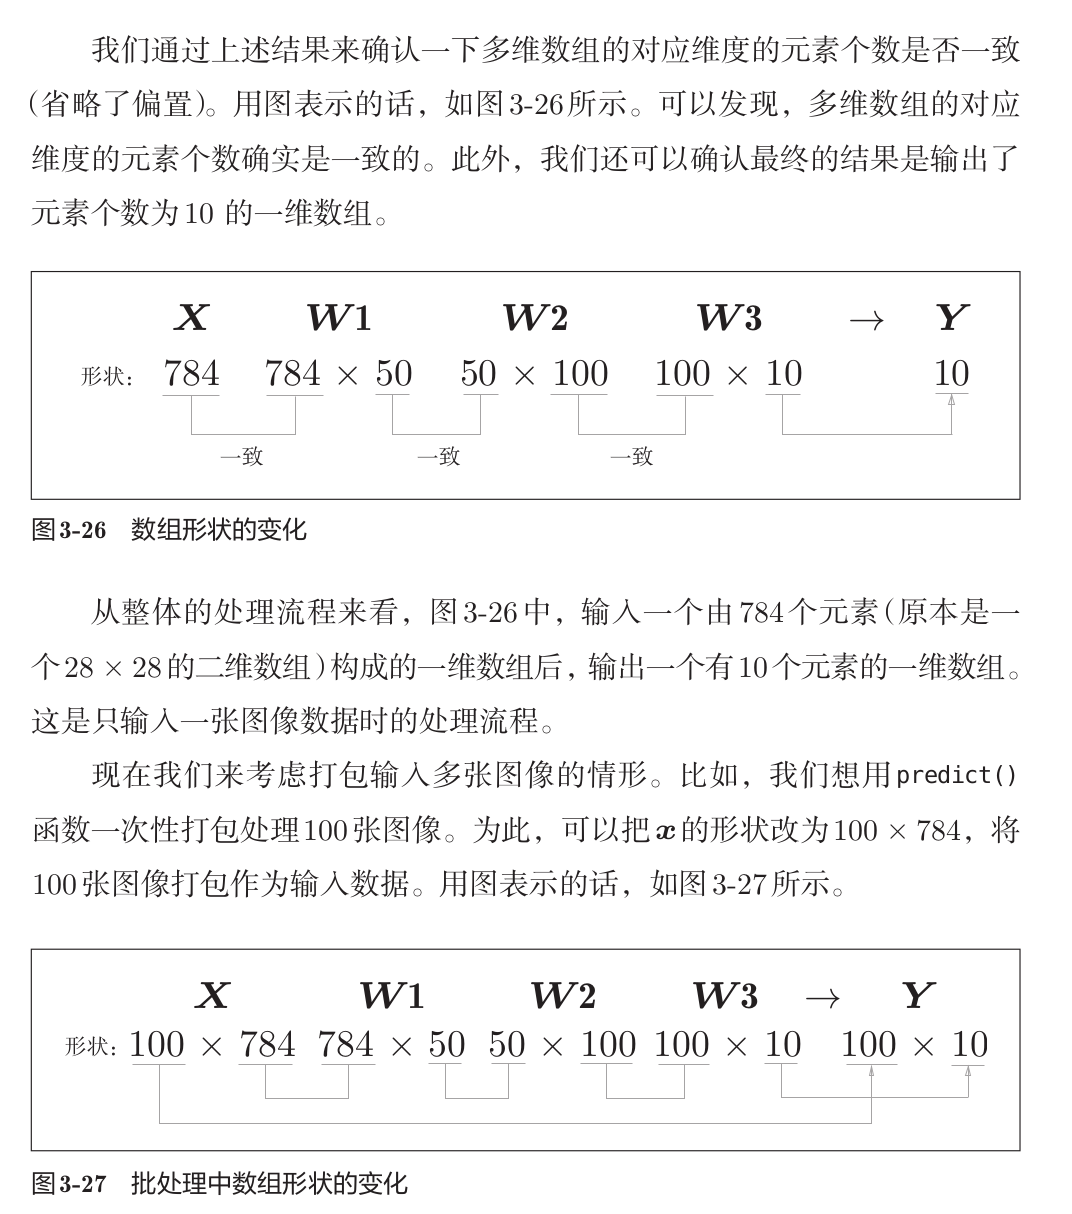

为什么可以用batch，batch相当于是提高了纵向维度，原来一次算一维，现在一次算多维

In [12]:
x, t = get_data()
network = init_network()
accuracy_cnt = 0
batch_size = 100
for i in range(0, len(x), batch_size):
    y = predict(network, x[i:i+batch_size])
    p = np.argmax(y, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


In [29]:
x, t = get_data()
network = init_network()
accuracy_cnt = 0

y = predict(network, x)
p = np.argmax(y, axis=1)
print(p.shape, p, x.shape, t.shape)
accuracy_cnt += np.sum(p == t)
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

(10000,) [7 2 1 ... 4 5 6] (10000, 784) (10000,)
Accuracy:0.9352


In [28]:
# Axis就是数组层级
# 设axis=i，则Numpy沿着第i个下标变化的方向进行操作, a[1][2]...[i] 变化的数字圈起来,比如axis=1， a[0][0], a[0][1],a[0][2] 圈起来去计算
# x.shape = (a1,a2,a3...)
# argmax(x, axis=i).shape = (a1, a2, ...ai-1, ai+1....), 看看原始数据怎么压缩成现在的维度

a = np.arange(18).reshape(2,3,3) + 10
print(a)
print(np.argmax(a))
print(np.argmax(a, axis=0))
print(np.argmax(a, axis=1))

print("xxxxxxxxxxxxxxxxxx")
a = np.array([1,2,3,4])
print(a.shape)
print(np.argmax(a, axis=0))
# print(np.argmax(a, axis=1))
print("xxxxxxxxxxxxxxxxxx")
a = np.array([[1,3],[2,3],[1,4]])
print(a)
print("xxxxxxxxxxxxxxxxxx")
print(a.shape)
print("xxxxxxxxxxxxxxxxxx")
print(np.argmax(a, axis=0))
print(np.argmax(a, axis=1))
print("xxxxxxxxxxxxxxxxxx")
print(np.sum(a, axis=0))
print(np.sum(a, axis=1))

[[[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]]
17
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[2 2 2]
 [2 2 2]]
xxxxxxxxxxxxxxxxxx
(4,)
3
xxxxxxxxxxxxxxxxxx
[[1 3]
 [2 3]
 [1 4]]
xxxxxxxxxxxxxxxxxx
(3, 2)
xxxxxxxxxxxxxxxxxx
[1 2]
[1 1 1]
xxxxxxxxxxxxxxxxxx
[ 4 10]
[4 5 5]


输出层的设计
回归问题用恒等函数，分类问题用 softmax 函数
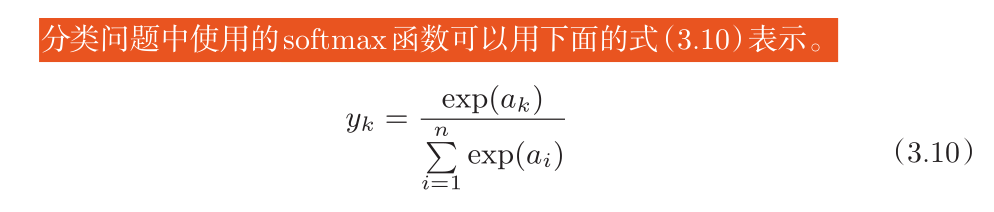
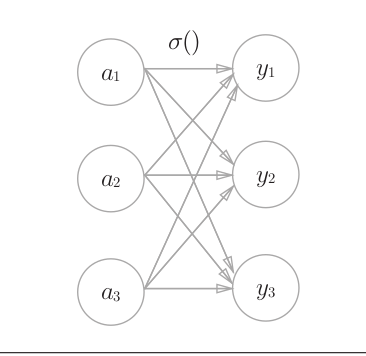

In [2]:
a=np.array([0.3, 2.9, 4.0])
exp_a=np.exp(a)
sum_exp_a=np.sum(exp_a)
y=exp_a/sum_exp_a
y

array([0.01821127, 0.24519181, 0.73659691])

softmax的溢出问题（e^100000）
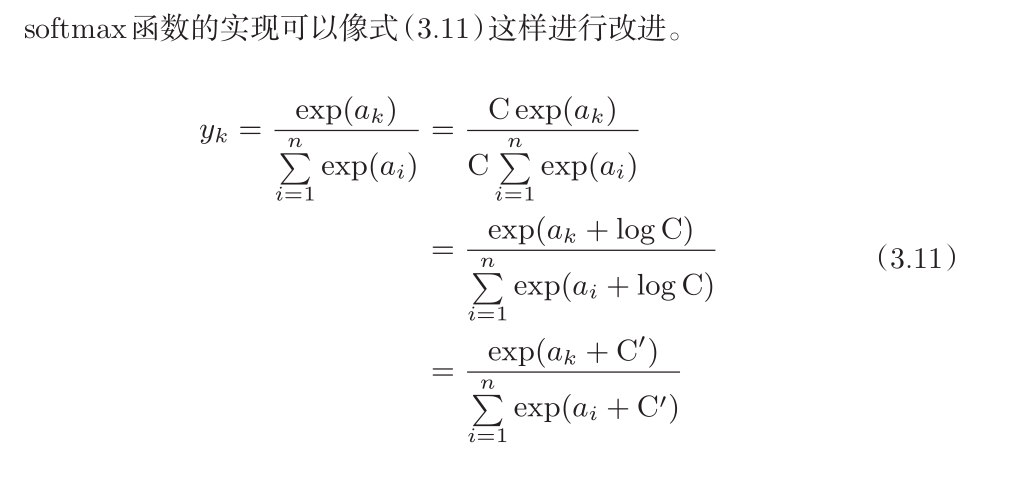

In [4]:
a=np.array([1010, 1000, 990])
# np.exp(a)/np.sum(np.exp(a)) # nan....
c=np.max(a)
np.exp(a-c)/np.sum(np.exp(a-c))

array([9.99954600e-01, 4.53978686e-05, 2.06106005e-09])

修改之后的softmax函数

In [ ]:
def softmax(a):
    c=np.max(a)
    return np.exp(a-c)/np.sum(np.exp(a-c))

softmax 函数的输出是 0.0 到 1.0 之间的实数。并且，softmax
函数的输出值的总和是 1。输出总和为 1 是 softmax 函数的一个重要性质。正
因为有了这个性质，我们才可以把 softmax 函数的输出解释为“概率”

这里需要注意的是，即便使用了 softmax 函数，各个元素之间的大小关
系也不会改变。这是因为指数函数（y = exp(x)）是单调递增函数。实际上，
上例中 a 的各元素的大小关系和 y 的各元素的大小关系并没有改变。比如，a
的最大值是第 2 个元素，y 的最大值也仍是第 2 个元素。
一般而言，神经网络只把输出值最大的神经元所对应的类别作为识别结果。
并且，即便使用 softmax 函数，输出值最大的神经元的位置也不会变。因此，
神经网络在进行分类时，输出层的 softmax 函数可以省略。在实际的问题中，
由于指数函数的运算需要一定的计算机运算量，因此输出层的 softmax 函数
一般会被省略。

推理阶段一般会省略输出层的 softmax 函数。在输出层使用 softmax 函数是因为它和神经网络的学习有关系.

为什么推理层需要用softmax？

输出层的神经元数量需要根据待解决的问题来决定。对于分类问题，输
出层的神经元数量一般设定为类别的数量。比如，对于某个输入图像，预测
是图中的数字 0 到 9 中的哪一个的问题（10 类别分类问题），可以像图 3-23 这样，
将输出层的神经元设定为 10 个

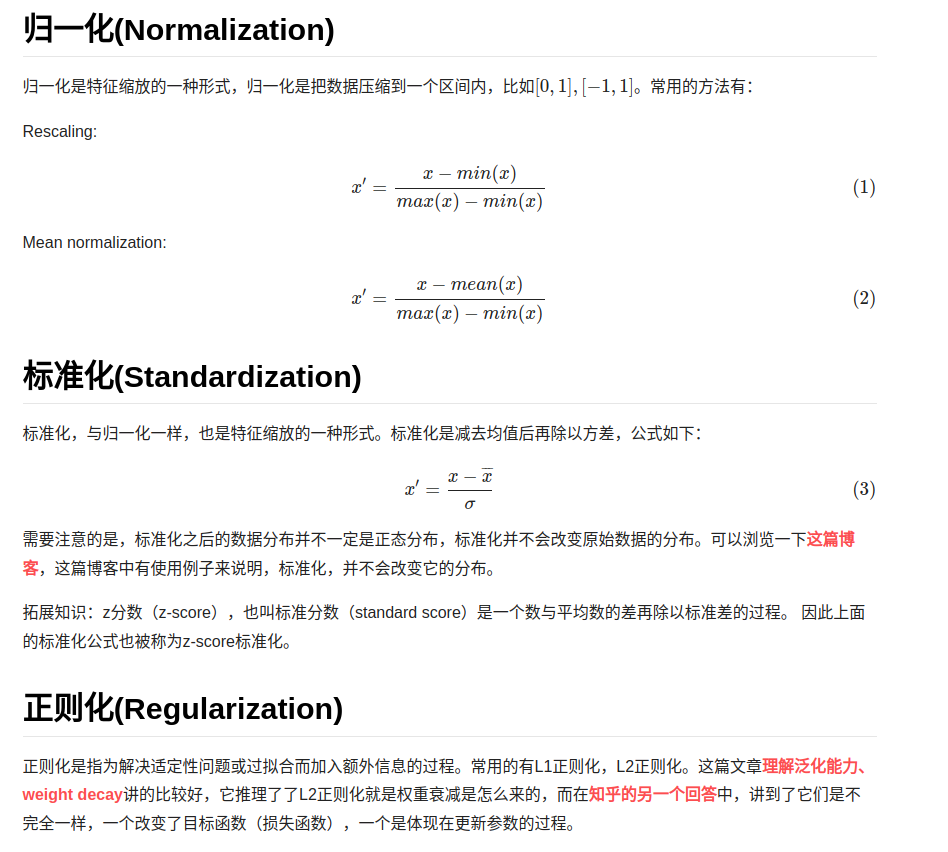
https://bingqiangzhou.github.io/2020/08/26/DailySummary-NormalizationStandardizationRegularization.html